<img width="100" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# MTBS to Zarr

_by Joe Hamman (CarbonPlan), June 17, 2020_

This notebook converts MTBS 30m yearly rasters stored in Cloud Optimized GeoTIFF and stages them in a single Zarr archive. 

**Inputs:**
- COG outputs from `01_raw_to_cogs.ipynb`

**Outputs:**
- 1 Zarr archive: `gs://carbonplan-data/processed/MTBS/raster.zarr/<RESOLUTION>/<VAR>`

**Notes:**
- In the process of processing this dataset, we found that the behavior in rasterio's `reproject` function was sensitive to the package version for rasterio and/or gdal. Versions we found to work were `rasterio=1.0.25,gdal=2.4.2`. Versions that we found to fail were `rasterio=1.1.5,gdal=3.1.0`

In [1]:
import os

import gcsfs
import numpy as np
import rasterio
import rioxarray
import xarray as xr
import zarr

from numcodecs.zlib import Zlib
from rasterio import Affine
from rasterio.warp import reproject, Resampling, transform
from rasterio.crs import CRS


scratch = os.environ['SCRATCH']

In [2]:
def base_crs():
    return (
        'PROJCS["Albers_Conical_Equal_Area",'
        'GEOGCS["WGS 84",DATUM["WGS_1984",'
        'SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],'
        "TOWGS84[0,0,0,-0,-0,-0,0],"
        'AUTHORITY["EPSG","6326"]],'
        'PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],'
        'UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],'
        'AUTHORITY["EPSG","4326"]],'
        'PROJECTION["Albers_Conic_Equal_Area"],'
        'PARAMETER["standard_parallel_1",29.5],'
        'PARAMETER["standard_parallel_2",45.5],'
        'PARAMETER["latitude_of_center",23],'
        'PARAMETER["longitude_of_center",-96],'
        'PARAMETER["false_easting",0],'
        'PARAMETER["false_northing",0],'
        'UNIT["meters",1]]'
    )


In [4]:
def make_dst_band(src_band, src_resolution):
    left = -2493045.0
    right = 2342655.0
    top = 3310005.0
    bottom = 177285.0
    dst_transform = Affine(30.0, 0.0, left, 0.0, -30.0, top)
    dst_resolution = dst_transform[0]
    dst_transform = dst_transform * Affine.scale(
        src_resolution / dst_resolution, src_resolution / dst_resolution
    )
    dst_crs = CRS.from_wkt(base_crs())

    dst_shape = [
        round((top - bottom) / src_resolution),
        round((right - left) / src_resolution),
    ]

    dst_band = np.zeros(dst_shape, np.float32)
    return dst_band, dst_transform, dst_crs, dst_shape


def calc_coords(shape, trans, crs):
    ny, nx = shape

    # crs coords
    x, _ = trans * (np.arange(nx) + 0.5, np.zeros(nx) + 0.5)
    _, y = trans * (np.zeros(ny) + 0.5, np.arange(ny) + 0.5)
    
    # convert to lat/lon
    xs, ys = np.meshgrid(x, y)
    lon, lat = transform(crs, {'init': 'EPSG:4326'}, xs.flatten(), ys.flatten())
    
    return {'x': xr.DataArray(x, dims=('x', )),
            'y': xr.DataArray(y, dims=('y', )),
            'lat': xr.DataArray(np.asarray(lat).reshape((ny, nx)), dims=('y', 'x')),
            'lon': xr.DataArray(np.asarray(lon).reshape((ny, nx)), dims=('y', 'x'))}


def prepare_mtbs(year, resolution, return_ds=True):
    src_path = f'gs://carbonplan-data/raw/MTBS/30m/{year}.tif'
    with rasterio.open(src_path, 'r') as src_raster:
        src_transform = src_raster.meta["transform"]
        src_crs = src_raster.meta["crs"]
        src_band = src_raster.read(1)
        src_resolution = resolution

        dst_band, dst_transform, dst_crs, dst_shape = make_dst_band(src_band, src_resolution)
        print('calc_coords')
        coords = calc_coords(dst_shape, dst_transform, dst_crs)

        src_nodata = 6
        if resolution == 30:
            resampling = Resampling.nearest
        elif resolution > 30:
            resampling = Resampling.average
            # set moderate or high burn severity to 1 and others to 1
            src_band_tmp = ((src_band == 3) | (src_band == 4)).astype("uint8")
            # set masked regions to nodata value
            src_band_tmp[src_band == src_nodata] = src_nodata
            src_band = src_band_tmp
            dst_band = dst_band.astype("float32")  # convert to float for averaging
            

        print('reproject')
        # this seems to require rasterio=1.0.25 and gdal=2.4.2
        reproject(
            src_band,
            dst_band,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=resampling,
            src_nodata=src_nodata,
            dst_nodata=src_raster.meta["nodata"],
        )

        meta = src_raster.meta
        meta.update(
            width=dst_shape[0],
            height=dst_shape[1],
            dtype=str(dst_band.dtype),
            crs=dst_crs.to_wkt(),
            transform=list(dst_transform),
            nodata=src_raster.meta["nodata"],
        )
    
    varname = f'{year}'
    chunks = {'x': 512, 'y': 512}
    ds = xr.DataArray(dst_band, dims=('y', 'x'), attrs=meta).to_dataset(name=varname)
    ds = ds.assign_coords(coords).chunk(chunks)
    

    if return_ds:
        return ds
    else:
        fs = gcsfs.GCSFileSystem(project='carbonplan', token='cloud', requester_pays=True)
        mapper = fs.get_mapper(scratch + f"/MTBS.{year}.{resolution}m.zarr")
        ds.to_zarr(store=mapper, mode='w', encoding={varname: {'compressor': Zlib()}})

In [5]:
years = list(range(1984, 2018))

dsets = [prepare_mtbs(y, 4000) for y in years]

calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coords
reproject
finish up
calc_coo

In [39]:
varname = 'burned_area'
da = xr.merge(dsets).to_array(dim='time', name=varname)
da['time'] = da.time.astype(int)
ds = da.to_dataset()
ds[varname].attrs.update(dsets[0]['1984'].attrs)
ds

<xarray.Dataset>
Dimensions:      (time: 34, x: 1209, y: 783)
Coordinates:
  * x            (x) float64 -2.491e+06 -2.487e+06 ... 2.337e+06 2.341e+06
  * y            (y) float64 3.308e+06 3.304e+06 3.3e+06 ... 1.84e+05 1.8e+05
    lat          (y, x) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>
  * time         (time) int64 1984 1985 1986 1987 1988 ... 2014 2015 2016 2017
Data variables:
    burned_area  (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

In [56]:
fs = gcsfs.GCSFileSystem(project='carbonplan', token='cloud', requester_pays=True)
mapper = fs.get_mapper("carbonplan-data/processed/MTBS/raster.zarr")

ds.to_zarr(store=mapper, group='4000m', mode='w', encoding={varname: {'compressor': Zlib()}})
    

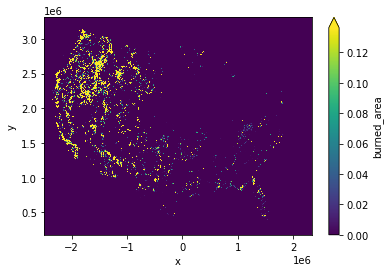

In [57]:
ds[varname].sum('time').plot(robust=True)

In [58]:
ds[varname]

<xarray.DataArray 'burned_area' (time: 34, y: 783, x: 1209)>
dask.array<stack, shape=(34, 783, 1209), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -2.491e+06 -2.487e+06 ... 2.337e+06 2.341e+06
  * y        (y) float64 3.308e+06 3.304e+06 3.3e+06 ... 1.84e+05 1.8e+05
    lat      (y, x) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>
  * time     (time) int64 1984 1985 1986 1987 1988 ... 2013 2014 2015 2016 2017
Attributes:
    driver:     GTiff
    dtype:      float32
    nodata:     0.0
    width:      783
    height:     1209
    count:      1
    crs:        PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS...
    transform:  [4000.0000000000005, 0.0, -2493045.0, 0.0, -4000.000000000000...